In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve_fft
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

In [2]:
dpath = Path.cwd().parent / "data"
pvpath2 = dpath / "pv-common"

## Look at 1D spectra

We can use the bg-subtracted files that we have just saved. Plot the Ha and oiii on the same graph. Show a series of spatial ranges:

In [39]:
file_list = sorted(pvpath2.glob("*-pv-coadd-bgsub.fits"))

linehdus = {
    filepath.stem.split("-")[0]: fits.open(filepath)[0]
    for filepath in file_list
}


positions = (
    ("N knot", [20.0, 30.0]),
    ("N outer", [9.0, 18.0]),
    ("N inner", [2.0, 6.0]),
    ("Core", [-1.5, 1.5]),
    ("S inner", [-6.0, -2.0]),    
    ("S outer", [-18.0, -9.0]),
    ("S knot", [-30.0, -20.0]),
)

nlines = len(file_list)
npos = len(positions)

In [40]:
linehdus

{'ha': <astropy.io.fits.hdu.image.PrimaryHDU at 0x7f7f383a8d30>,
 'heii': <astropy.io.fits.hdu.image.PrimaryHDU at 0x7f7f5225c0d0>,
 'nii': <astropy.io.fits.hdu.image.PrimaryHDU at 0x7f7f5225cc40>,
 'oiii': <astropy.io.fits.hdu.image.PrimaryHDU at 0x7f7f18fffdf0>}

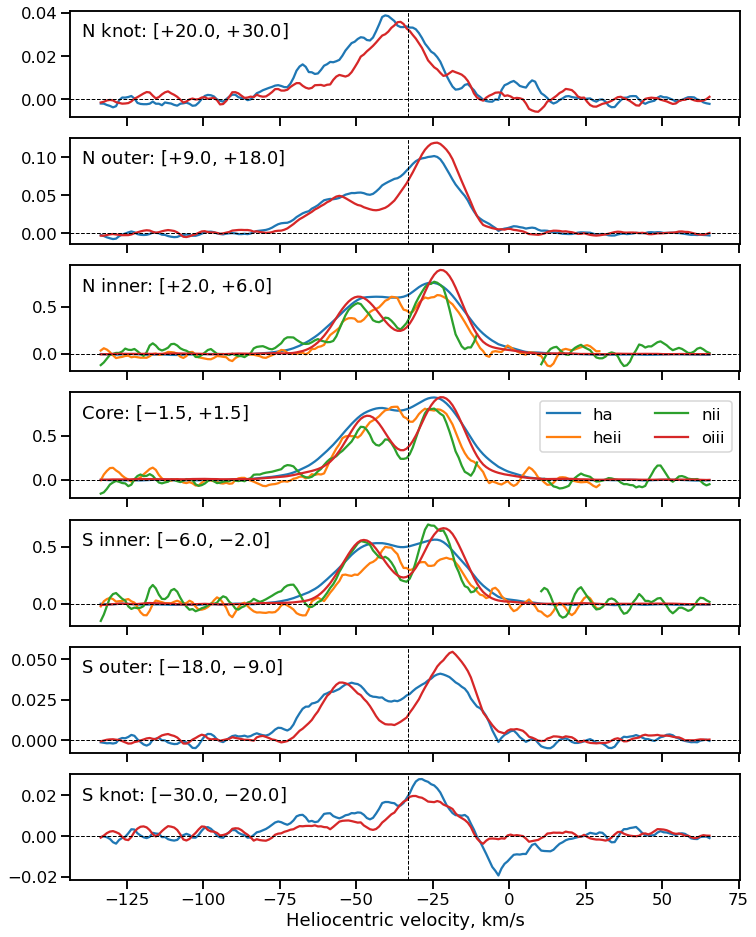

In [42]:
fig, axes = plt.subplots(
    npos, 
    1, 
    sharex=True,
    figsize=(12, 16),
)

vsys = -33
v1, v2 = vsys - 100, vsys + 100

skip = ["heii", "nii"]
for ax, [pos_label, [s1, s2]] in zip(axes, positions):
    for line_label, hdu in linehdus.items():
        w = WCS(hdu.header)
        ns, nv = hdu.data.shape
        xlims, ylims = w.world_to_pixel_values([v1, v2], [s1, s2])
        x1, x2 = [int(_) for _ in xlims]
        y1, y2 = [int(_) for _ in ylims]
        spec = hdu.data[y1:y2, x1:x2].mean(axis=0)
        vels, _ = w.pixel_to_world_values(np.arange(nv), [0]*nv)
        vels = vels[x1:x2]
        if line_label == "nii":
            spec[np.abs(vels) <= 10.0] = np.nan
        if line_label == "heii":
            spec[vels >= 30.0] = np.nan
        if line_label in skip and np.abs([s1, s2]).min() > 4:
            spec[:] = np.nan
        ax.plot(vels, spec, label=line_label)
    ax.axhline(0.0, linestyle="dashed", c="k", lw=1,)
    ax.axvline(vsys, linestyle="dashed", c="k", lw=1,)
    axtitle = f"  {pos_label}: [${s1:+.1f}$, ${s2:+.1f}$]"
    ax.set_title(axtitle, loc="left", y=0.7)
axes[3].legend(ncol=2)
axes[-1].set(
    xlabel="Heliocentric velocity, km/s",
)
figfile = "ou5-coadd-1dspec-all.pdf"
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))
...;

That version has all the lines for the brighter parts.  But, to be honest, they do not really add anything. 

In [24]:
from astropy.modeling import models, fitting

In [25]:
def mark_component(model, color, ax):
    v = model.mean.value
    a = model.amplitude.value
    ax.plot([v, v], [0.3 * a, 0.7 * a], lw=3, color=color, alpha=0.7)

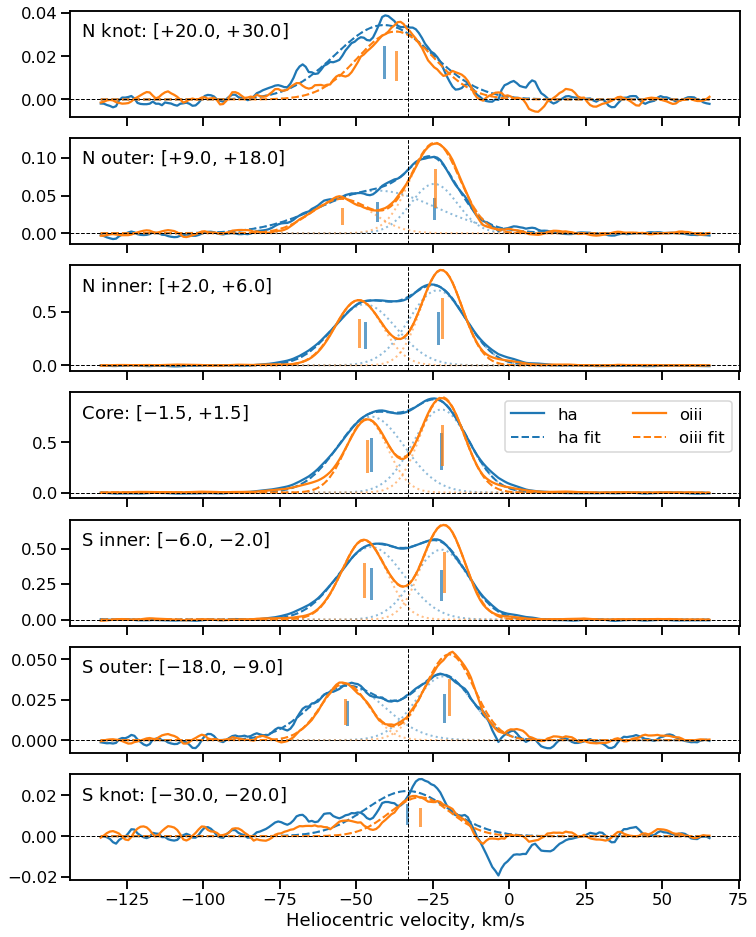

In [43]:
fig, axes = plt.subplots(
    npos, 
    1, 
    sharex=True,
    figsize=(12, 16),
)

vsys = -33c
v1, v2 = vsys - 100, vsys + 100
fitter = fitting.LevMarLSQFitter()
keep = ["ha", "oiii"]
gfits = {}
for ax, [pos_label, [s1, s2]] in zip(axes, positions):
    for line_label, hdu in linehdus.items():
        if not line_label in keep:
            continue
        w = WCS(hdu.header)
        ns, nv = hdu.data.shape
        xlims, ylims = w.world_to_pixel_values([v1, v2], [s1, s2])
        x1, x2 = [int(_) for _ in xlims]
        y1, y2 = [int(_) for _ in ylims]
        spec = hdu.data[y1:y2, x1:x2].mean(axis=0)
        vels, _ = w.pixel_to_world_values(np.arange(nv), [0]*nv)
        vels = vels[x1:x2]
        dataline, = ax.plot(vels, spec, label=line_label)
        c = dataline.get_color()
        
        # Fit two Gaussians
        mask1 = vels < vsys
        mask2 = ~mask1
        sm1 = spec[mask1].max()
        vm1 = vels[spec[mask1].argmax()]
        sm2 = spec[mask2].max()
        vm2 = vels[spec[mask2].argmax() + mask1.sum()]
        g1 = models.Gaussian1D(amplitude=sm1, mean=vm1, stddev=10.0)
        g2 = models.Gaussian1D(amplitude=sm2, mean=vm2, stddev=10.0)
        if "knot" in pos_label:
            init_model = g1
            fac = -0.5
        elif "outer" in pos_label:
            init_model = g1 + g2
            fac = 0.02           
        else:
            init_model = g1 + g2
            fac = 0.3
        fitmask = spec > fac * spec.max()
        fitted_model = fitter(init_model, vels[fitmask], spec[fitmask])
        gfits[(line_label, pos_label)] = fitted_model
        ax.plot(
            vels, 
            fitted_model(vels), 
            linestyle="dashed", 
            lw=2, 
            c=c,
            label=f"{line_label} fit",
        )
        if "knot" in pos_label:
            # special case of 1 component, therefore not compound model
            fitted_model = [fitted_model]
        for component in fitted_model:
            mark_component(component, c, ax)
            ax.plot(
                vels, 
                component(vels), 
                linestyle="dotted", 
                lw=2, 
                c=c,
                alpha=0.5,
            )


    ax.axhline(0.0, linestyle="dashed", c="k", lw=1,)
    ax.axvline(vsys, linestyle="dashed", c="k", lw=1,)
    axtitle = f"  {pos_label}: [${s1:+.1f}$, ${s2:+.1f}$]"
    ax.set_title(axtitle, loc="left", y=0.7)
axes[3].legend(ncol=2)
axes[-1].set(
    xlabel="Heliocentric velocity, km/s",
)
figfile = "ou5-coadd-1dspec-ha-oiii.pdf"
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))
...;

Now zoom the y axis, to look at the wings, but just for the inner regions:

In [44]:
cpos = {
    k: v for k, v in positions
    if np.abs(v).min() < 4
}
cpos

{'N inner': [2.0, 6.0], 'Core': [-1.5, 1.5], 'S inner': [-6.0, -2.0]}

In [45]:
def mark_component_low(model, color, ax):
    v = model.mean.value
    a = model.amplitude.value
    ax.plot([v, v], [0.03, 0.07], lw=3, color=color, alpha=0.7)

In [46]:
from astropy.convolution import convolve_models

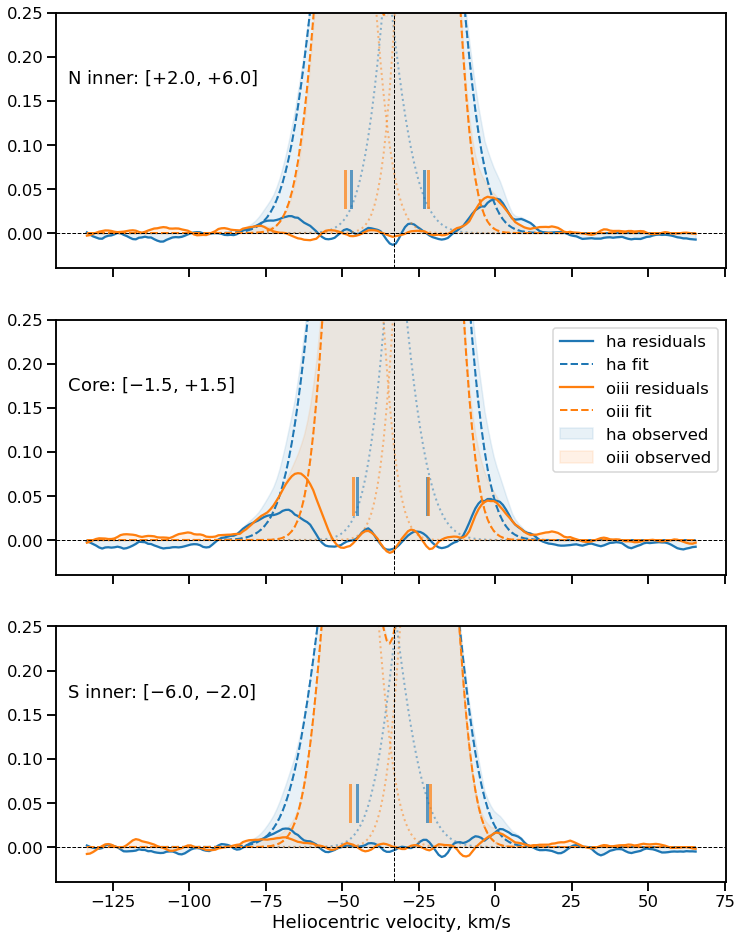

In [47]:
fig, axes = plt.subplots(
    len(cpos), 
    1, 
    sharex=True,
    figsize=(12, 16),
)

vsys = -33
v1, v2 = vsys - 100, vsys + 100
fitter = fitting.LevMarLSQFitter()
keep = ["ha", "oiii"]
gfits2 = {}
for ax, [pos_label, [s1, s2]] in zip(axes, cpos.items()):
    for line_label, hdu in linehdus.items():
        if not line_label in keep:
            continue
        w = WCS(hdu.header)
        ns, nv = hdu.data.shape
        xlims, ylims = w.world_to_pixel_values([v1, v2], [s1, s2])
        x1, x2 = [int(_) for _ in xlims]
        y1, y2 = [int(_) for _ in ylims]
        spec = hdu.data[y1:y2, x1:x2].mean(axis=0)
        vels, _ = w.pixel_to_world_values(np.arange(nv), [0]*nv)
        vels = vels[x1:x2]
        # Fit two Gaussians
        mask1 = vels < vsys
        mask2 = ~mask1
        sm1 = spec[mask1].max()
        vm1 = vels[spec[mask1].argmax()]
        sm2 = spec[mask2].max()
        vm2 = vels[spec[mask2].argmax() + mask1.sum()]
        g1 = models.Gaussian1D(amplitude=sm1, mean=vm1, stddev=10.0)
        g2 = models.Gaussian1D(amplitude=sm2, mean=vm2, stddev=10.0)
        g1b = models.Gaussian1D(amplitude=0.1 * sm1, mean=vm1, stddev=3.0)
        g2b = models.Gaussian1D(amplitude=0.1 * sm2, mean=vm2, stddev=3.0)

        init_model = g1 + g2 #+ g1b + g2b
        fitmask = spec > 0.3 * spec.max()
        fitted_model = fitter(init_model, vels[fitmask], spec[fitmask])
        #fitted_model = fitter(init_model, vels, spec)
        gfits2[(line_label, pos_label)] = fitted_model



        dataline, = ax.plot(
            vels, 
            spec - fitted_model(vels), 
            label=f"{line_label} residuals",
        )
        c = dataline.get_color()
        ax.fill_between(vels, 0.0, spec, color=c, alpha=0.1, label=f"{line_label} observed")
        ax.plot(
            vels, 
            fitted_model(vels), 
            linestyle="dashed", 
            lw=2, 
            c=c,
            label=f"{line_label} fit",
        )
        for component in fitted_model[:2]:
            mark_component_low(component, c, ax)
        for component in fitted_model:
            ax.plot(
                vels, 
                component(vels), 
                linestyle="dotted", 
                lw=2, 
                c=c,
                alpha=0.5,
            )

           

    ax.axhline(0.0, linestyle="dashed", c="k", lw=1,)
    ax.axvline(vsys, linestyle="dashed", c="k", lw=1,)
    axtitle = f"  {pos_label}: [${s1:+.1f}$, ${s2:+.1f}$]"
    ax.set_title(axtitle, loc="left", y=0.7)
    ax.set(ylim=[-0.04, 0.25])
axes[1].legend(ncol=1)
axes[-1].set(
    xlabel="Heliocentric velocity, km/s",
)
figfile = "ou5-coadd-1dspec-wings.pdf"
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))
...;

In [48]:
import pandas as pd

In [49]:
m = gfits[("oiii", "Core")]
dict(zip(m.param_names, m.parameters))

{'amplitude_0': 0.7271135703970121,
 'mean_0': -46.53479685855003,
 'stddev_0': 6.82973139029844,
 'amplitude_1': 0.9455225401046431,
 'mean_1': -21.851898863190094,
 'stddev_1': 7.1149808747502234}

In [53]:
pd.set_option('display.precision', 2)
df = pd.DataFrame(
    {k: dict(zip(m.param_names, m.parameters)) for k, m in gfits.items()}
).T
df.style.format(na_rep='—')

,,amplitude,mean,stddev,amplitude_0,mean_0,stddev_0,amplitude_1,mean_1,stddev_1
ha,N knot,0.03,-40.90,15.82,—,—,—,—,—,—
oiii,N knot,0.03,-37.07,12.60,—,—,—,—,—,—
ha,N outer,—,—,—,0.06,-43.03,19.14,0.07,-24.53,7.56
oiii,N outer,—,—,—,0.05,-54.77,9.90,0.12,-24.19,8.02
ha,N inner,—,—,—,0.57,-47.19,10.41,0.70,-23.40,9.39
oiii,N inner,—,—,—,0.61,-49.11,7.66,0.89,-22.08,6.73
ha,Core,—,—,—,0.75,-45.13,10.91,0.82,-22.20,9.13
oiii,Core,—,—,—,0.73,-46.53,6.83,0.95,-21.85,7.11
ha,S inner,—,—,—,0.51,-45.16,10.84,0.49,-22.16,8.94
oiii,S inner,—,—,—,0.56,-47.42,7.38,0.67,-21.41,6.89


## Compare with 2D spectra

Repeat from previous notebook, but add positions

In [51]:
positions

(('N knot', [20.0, 30.0]),
 ('N outer', [9.0, 18.0]),
 ('N inner', [2.0, 6.0]),
 ('Core', [-1.5, 1.5]),
 ('S inner', [-6.0, -2.0]),
 ('S outer', [-18.0, -9.0]),
 ('S knot', [-30.0, -20.0]))

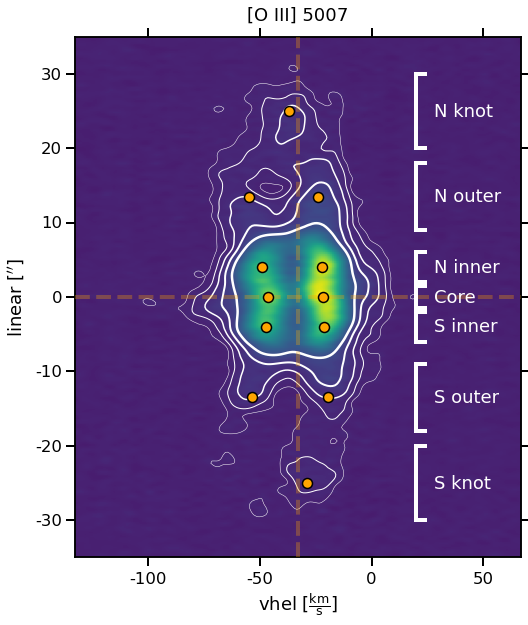

In [59]:
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=w))

vsys = -33
v1, v2 = vsys - 100, vsys + 100
s1, s2 = -35, 35

kernel = Gaussian2DKernel(x_stddev=2.0)
hdu = linehdus["oiii"]
w = WCS(hdu.header)
xlims, ylims = w.world_to_pixel_values([v1, v2], [s1, s2])
y1, y2 = [int(_) for _ in ylims]
x1, x2 = [int(_) for _ in xlims]
im = hdu.data
ax.imshow(im, vmin=-0.1, vmax=1.0)
ims = convolve_fft(im, kernel)
ax.contour(
    ims, 
    levels=[0.01, 0.02, 0.04, 0.08, 0.16], 
    colors="w",
    linewidths=[0.5, 1.0, 1.5, 2.0, 2.5],
)
x0, y0 = w.world_to_pixel_values(vsys, 0.0)
ax.axhline(y0, color="orange", ls="dashed", lw=4, alpha=0.3)
ax.axvline(x0, color="orange", ls="dashed", lw=4, alpha=0.3)


# Add markers for the extracted regions
xp = 20.0
trw = ax.get_transform("world")
for plabel, ypp in positions:
    ax.plot([xp, xp], ypp, c="w", lw=4, transform=trw)
    for yp in ypp:
        ax.plot([xp, xp + 4], [yp, yp], c="w", lw=4, transform=trw)
    ax.text(xp + 8, np.mean(ypp), plabel, color="w", ha="left", va="center", transform=trw)

    
# Add markers for the Gaussian components
for plabel, ypp in positions:
    model = gfits[("oiii", plabel)]
    vmeans = [
        param 
        for name, param in zip(model.param_names, model.parameters)
        if name.startswith("mean")
    ]
    for vmean in vmeans:
        ax.scatter(
            vmean, 
            np.mean(ypp), 
            marker="o", 
            s=100, 
            c='orange',
            ec="k",
            alpha=1.0, 
            transform=trw,
            zorder=100,
        )
ax.set(xlim=xlims, ylim=ylims)
ax.set_title("[O III] 5007", pad=16)
figfile = "ou5-coadd-2dspec-oiii.pdf"
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))
...;

In [60]:
df = df.assign(dv=df.mean_1 - df.mean_0)

In [61]:
df.style.format(na_rep='—')

,,amplitude,mean,stddev,amplitude_0,mean_0,stddev_0,amplitude_1,mean_1,stddev_1,dv
ha,N knot,0.03,-40.90,15.82,—,—,—,—,—,—,—
oiii,N knot,0.03,-37.07,12.60,—,—,—,—,—,—,—
ha,N outer,—,—,—,0.06,-43.03,19.14,0.07,-24.53,7.56,18.50
oiii,N outer,—,—,—,0.05,-54.77,9.90,0.12,-24.19,8.02,30.57
ha,N inner,—,—,—,0.57,-47.19,10.41,0.70,-23.40,9.39,23.79
oiii,N inner,—,—,—,0.61,-49.11,7.66,0.89,-22.08,6.73,27.03
ha,Core,—,—,—,0.75,-45.13,10.91,0.82,-22.20,9.13,22.93
oiii,Core,—,—,—,0.73,-46.53,6.83,0.95,-21.85,7.11,24.68
ha,S inner,—,—,—,0.51,-45.16,10.84,0.49,-22.16,8.94,23.00
oiii,S inner,—,—,—,0.56,-47.42,7.38,0.67,-21.41,6.89,26.01


## Try fitting Gaussians to all the rows

Use bins of size 1 arcsec

In [77]:
fine_pix = 1.0
fine_positions = np.arange(-28, 29) * fine_pix
fine_positions

array([-28., -27., -26., -25., -24., -23., -22., -21., -20., -19., -18.,
       -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,
        -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,
         5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
        27.,  28.])

In [78]:
sys = -33
v1, v2 = vsys - 100, vsys + 100
fitter = fitting.LevMarLSQFitter()
finefits = {}
hdu = linehdus["oiii"]
w = WCS(hdu.header)
ns, nv = hdu.data.shape

for finepos in fine_positions:
    s1, s2 = finepos - 0.5 * fine_pix, finepos + 0.5 * fine_pix 
    xlims, ylims = w.world_to_pixel_values([v1, v2], [s1, s2])
    x1, x2 = [int(_) for _ in xlims]
    y1, y2 = [int(_) for _ in ylims]
    spec = hdu.data[y1:y2+1, x1:x2+1].mean(axis=0)
    vels, _ = w.pixel_to_world_values(np.arange(nv), [0]*nv)
    vels = vels[x1:x2+1]
    sm = spec.max()
    g1 = models.Gaussian1D(amplitude=sm, mean=-50, stddev=10.0)
    g2 = models.Gaussian1D(amplitude=sm, mean=-20, stddev=10.0)
    init_model = g1 + g2
    fitted_model = fitter(init_model, vels, spec)
    finefits[finepos] = fitted_model
...;

In [79]:
fdf = pd.DataFrame(
    {k: dict(zip(m.param_names, m.parameters)) for k, m in finefits.items()}
).T
fdf.style.format(na_rep='—')

,amplitude_0,mean_0,stddev_0,amplitude_1,mean_1,stddev_1
-28.0,0.02,-51.63,3.44,0.01,-30.38,6.50
-27.0,0.01,-51.03,3.64,0.02,-29.44,7.99
-26.0,0.01,-59.85,4.78,0.02,-30.06,9.03
-25.0,0.01,-62.67,7.58,0.03,-27.19,7.05
-24.0,0.01,-64.55,8.46,0.03,-26.58,8.47
-23.0,0.01,-62.58,7.24,0.03,-28.45,8.68
-22.0,0.01,-52.55,41.86,0.02,-26.97,7.96
-21.0,0.00,-71.64,66.62,0.01,-26.74,12.52
-20.0,0.01,-64.53,6.75,0.01,-26.38,17.76
-19.0,0.01,-61.55,8.11,0.01,-22.48,16.21


<AxesSubplot:>

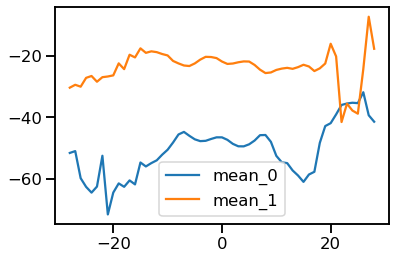

In [80]:
fdf[["mean_0", "mean_1"]].plot()

/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


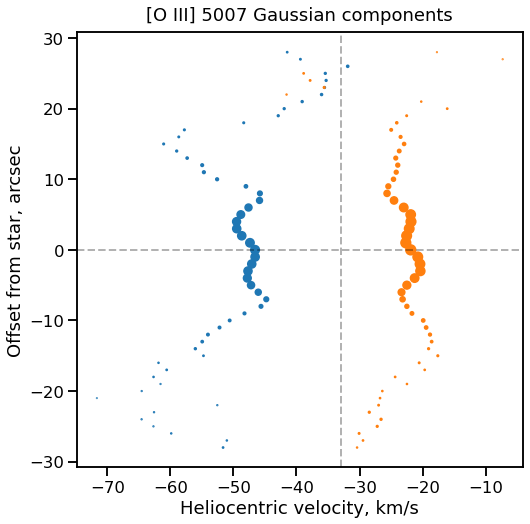

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    fdf["mean_0"], 
    fdf.index,
    s=100 * fdf["amplitude_0"],    
)
ax.scatter(
    fdf["mean_1"], 
    fdf.index,
    s=100 * fdf["amplitude_1"],    
)
ax.axhline(0.0, color="k", ls="dashed", lw=2, alpha=0.3)
ax.axvline(vsys, color="k", ls="dashed", lw=2, alpha=0.3)
ax.set(
    xlabel="Heliocentric velocity, km/s",
    ylabel="Offset from star, arcsec",
)
ax.set_title("[O III] 5007 Gaussian components", pad=12)
figfile = "ou5-coadd-pv-oiii-gaussians.pdf"
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))
...;